<a href="https://colab.research.google.com/github/gabriel-barata/APS-Failure-Prediction-in-Scania-Trucks/blob/main/APS_FAILURE_PREDICTION_ON_SCANIA_TRUCKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Scania Air Pressure System Failures Prediction

### Problem

Some industries, as the transportation and logistic sector, widely uses trucks. Therefore an out of order truck represents a great cost for companies. To avoid this, the trucks go trought periodic maintenance, it brings us 3 possibilities:
1. The equipment is maintened too frequently. In other words, the machine gets maintenance when it is not required. In that case, money is unecessary spend.
2. The equipment is not maintened frequently enough. It means the machine will break while operating. The costs associated to this possibility is substantial, since there are the repair costs and the lost profit for truck downtime.
3. The machine is maintened when it needs maintenance, minimizing the costs.

### Proposed Solution

This kernel uses data collected from heavy Scania trucks in everyday usage and machine learning algorithms to predict failures on trucks's APS(Air Pressure system which generates pressurised air that are utilized in various functions in a truck, such as breaking and gear changes) and optimize the maintainance on goal to minimize costs.

The costs for maintainance and vehicle downtime depends on situation, but for performance control reasons we're assuming that the maintainance costs 1.500 per truck, and a breakdown costs 20.000 per truck. In that way, assuming a small company with a fleet of 2000 trucks, we have:

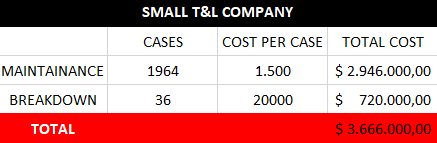

The main objective of this job is reduce the costs for maintainance for that small company, and to reach this we'll use data science.

# Set Up

## Imports
Importing the necessary libraries for this job.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC

from google.colab import drive
import warnings

## Globals & Settings
Some global variables and parameters that will be used in this entire notebook. 

In [3]:
# Mounting drive and reading files
drive.mount('/content/drive/')
#!unzip '/content/drive/MyDrive/BASES DE DADOS/SCANIA/SCANIA DATA.zip' &> /dev/null
data_raw = pd.read_csv('aps_failure_training_set.csv', na_values = 'na')
temp = pd.read_csv('/content/aps_failure_test_set.csv', na_values = 'na')
data_raw = pd.concat([data_raw, temp], axis = 0)

# Viz settings
matplotlib.rcParams['axes.facecolor'] = '#E5E5E5'
BLUE = '#0C9DB1'
warnings.filterwarnings('ignore')

# Data settings
target = data_raw['class']

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data Pre-Processing

## NaN values and Outliers

One of the biggest problems dealing with this data is the great number of rows with missings values. The plot below show the % of missing values for each column in our dataframe. For this approach we decided to drop the columns with more than 40%(9 columns) of its values missing. The rest will be filled with the median since its not sensitive to outliers.

Outliers

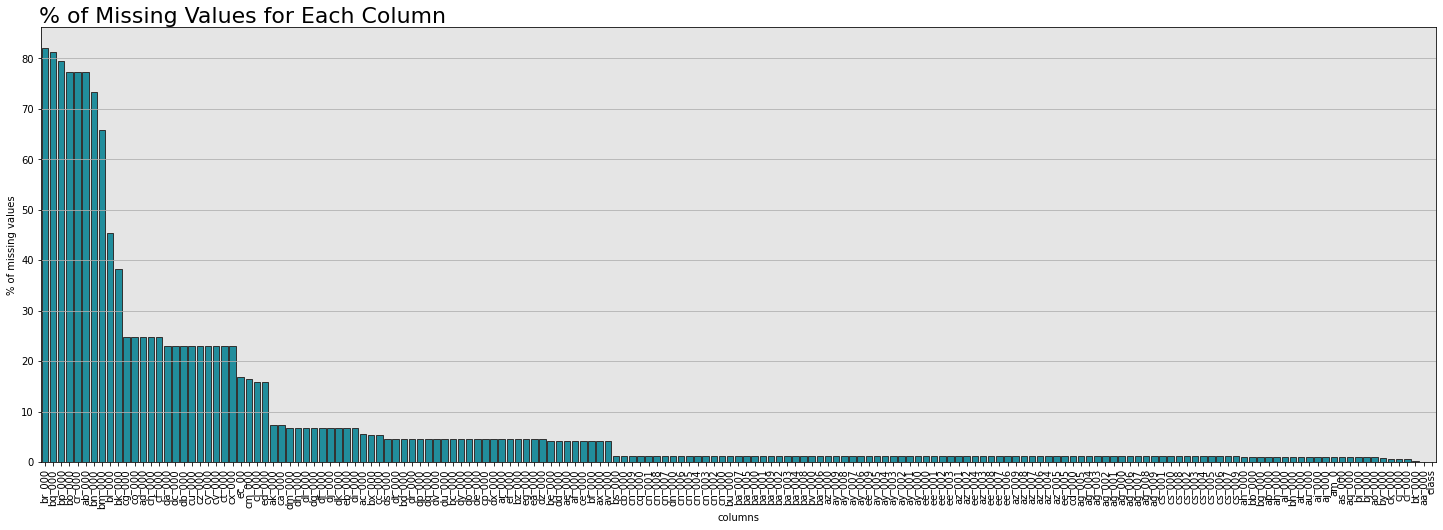

In [4]:
data_raw.reset_index(drop = True, inplace = True)
missing_values = data_raw.isna().sum().div(len(data_raw)).reset_index()
missing_values.rename(columns = {0 : 'missing_%',
                                 'index' : 'column'}, inplace = True)
missing_values['missing_%'] = missing_values['missing_%'].apply(lambda x: x*100)
missing_values.sort_values(by = 'missing_%', ascending = False, inplace = True)

plt.figure(figsize = (25,8))
sns.barplot(x = 'column',
            y = 'missing_%',
            data = missing_values,
            linewidth = 1,
            edgecolor=".2",
            color = BLUE)
plt.xlabel('columns')
plt.ylabel('% of missing values')
plt.suptitle('% of Missing Values for Each Column', x = 0.237, y = 0.915, fontsize = 22)
plt.xticks(rotation = 90)
plt.grid(axis = 'y')
plt.show()

temp = list(missing_values.loc[missing_values['missing_%'] > 40]['column'])
data_raw.drop(temp, axis = 1, inplace = True)

data_raw.fillna(data_raw.median(), inplace = True)

## Feature Engineering

Here we prepare the data before pass it into the model. All the steps that are done here was done before in another kernel, to see it in detail visit : https://github.com/gabriel-barata/APS-Failure-Prediction-in-Scania-Trucks/blob/main/DATA_PRE_PROCESS.ipynb.

+ step 1 : The data will be standardized, using z-score, since the features are in different scales, and standardized data showed to return better results.

+ step 2 : Apply SMOTE to the data, it's the synthetic minority oversampling technique, was aplied on objeticve to reduce the huge difference in data availability for each class. This technique created synthetic samples of data from trucks who had APS failures to balance data. Also, the model performed better results with SMOTE.

+ step 3 : Remove from the dataset the least descriptive features. Thanks to a violin plot analysis of the features, we was able to find the less descriptive ones. They was then dropped, this avoid overfitting. This step brought a great improvement on results. 


In [5]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(data_raw.drop('class', axis = 1))
std_data = scaler.transform(data_raw.drop('class', axis = 1))

temp = pd.DataFrame(std_data, columns = data_raw.drop('class', axis = 1).columns)
std_data = pd.concat([temp, data_raw['class']], axis = 1)
std_data['class'] = std_data['class'].apply(lambda x: 0 if x == 'neg' else 1)

# Creating a SMOTE pipeline
oversample = SMOTE(sampling_strategy = 0.7)
undersample = RandomUnderSampler()

steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps = steps)

# Removing the least descriptive features
data = std_data.drop(['ac_000', 'cs_000', 'cd_000', 'ef_000', 'eg_000', 'du_000',
                      'dp_000', 'ea_000', 'df_000', 'dc_000', 'ct_000', 'cu_000',
                      'db_000', 'ce_000', 'ak_000', 'as_000', 'cg_000', 'ca_000', 'cb_000'], axis = 1)

# Model Implementation

Here we implement the model, Support Vector Machine, train it and get the results.
This model was choosen purposely due it's sensitivity to outliers.
Before training, the data will be splited into data for **train** and **test**(for evaluation), and SMOTE will be aplied.

In [6]:
# Splitting into train and test
np.random.seed(16)
features = data.drop('class', axis = 1)
target = data['class']

x_train, x_test, y_train, y_test = train_test_split(features, target, stratify = target, test_size = 0.2)
# Resampling data
x_resampled, y_resampled = pipeline.fit_resample(x_train, y_train)

model = SVC(gamma = 'scale', kernel = 'rbf', C = 1.0)
model.fit(x_resampled, y_resampled)
predictions = model.predict(x_test)

# Model Evaluation

The evaluation was done on the test data. From metrics, the most important for us is the recall, that represents the percentage of model's correct guesses given what it tried to predict. For non failure the model had an recall of 98% and for failure the model had a recall of 92%. That is, for every 100 failures that the model predicts, 92 actually happen.

The confusion matrix shows us the number of errors and successes of the model. The diagonal represents the correct guesses (True Negatives - True Positives) and the off diagonal shows us the model errors(False Positives - False Negatives)

Assuming that the APS maitainance costs 3.000 and a truck that was incorrectly diagnosed without failures on APS costs 21.500 (breakdown + maintaince costs) our model gets a new total value for maintainace of 3.163.500 dollars.

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14925
           1       0.47      0.92      0.62       275

    accuracy                           0.98     15200
   macro avg       0.73      0.95      0.81     15200
weighted avg       0.99      0.98      0.98     15200





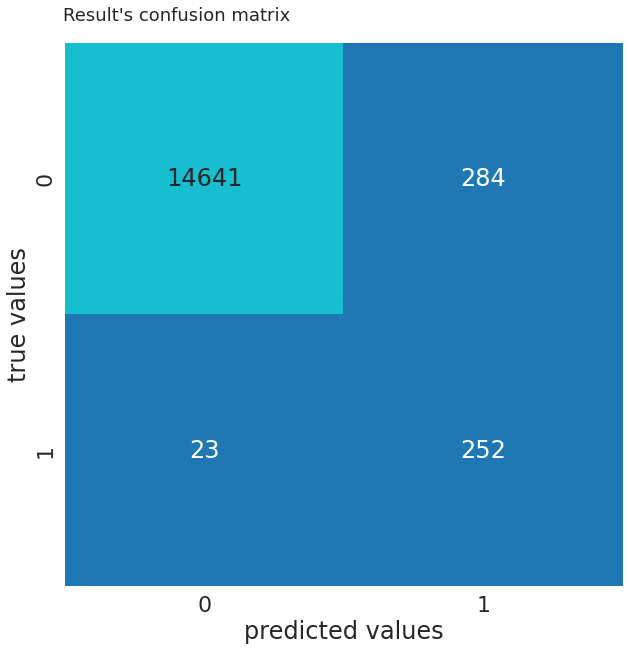



The model predictions bring savings of $502500.00, new total value : 3163500.00


In [23]:
# Model Metrics
report = classification_report(y_test, predictions)
print(report)
print('\n')

plt.figure(figsize = (10,10))
matrix = confusion_matrix(y_test, predictions)
sns.heatmap(matrix, annot = True, cbar=False, cmap = 'tab10', fmt = '.0f')
sns.set(font_scale = 2)
plt.suptitle("Result's confusion matrix", x = 0.28, y = 0.93, fontsize = 18)
plt.xlabel('predicted values')
plt.ylabel('true values')
plt.show()
print('\n')

# Converting model's metrics to monetary values
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
total = tn + fp + fn + tp
var_1 = round((tn/total)*2000)*1500
var_2 = round((fp/total)*2000)*3000
var_3 = round((fn/total)*2000)*21500
var_4 = round((tp/total)*2000)*3000

sum = var_1 + var_2 + var_3 + var_4
eco = (3666000 - sum)

print(f'The model predictions bring savings of ${eco:.2f}, new total value : {sum:.2f}')

# Conclusion

Assuming the initial situation with the T&L company with a 2000 trucks fleet, the initial costs for truck's maitainance was on 3.666.000 dollars. With our model, the costs can be reduced to 3.163.500 dollars, a reduction of 14% on initial costs, saving **$502,500** on every maintainace period.
